# CS4487 - Machine Learning
# Lecture 7 - Linear Dimensionality Reduction
## Dr. Antoni B. Chan
### Dept. of Computer Science, City University of Hong Kong

# Outline
1. Linear Dimensionality Reduction for Vectors
  1. Principal Component Analysis (PCA)  
  2. Random Projections
  3. Fisher's Linear Discriminant (FLD)
2. Linear Dimensionality Reduction for Text
  1. Latent Semantic Analysis (LSA)  
  2. Non-negative Matrix Factorization (NMF)
  3. Latent Dirichlet Allocation (LDA)

In [1]:
# setup
%matplotlib inline
import IPython.core.display         # setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D

D:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
D:\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
D:\Anaconda3\lib\site-packages\sklearn\learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


# Dimensionality Reduction
- **Goal:** Transform high-dimensional vectors into low-dimensional vectors.
  - Dimensions in the low-dim data represent co-occuring features in high-dim data.
  - Dimensions in the low-dim data may have semantic meaning.
- **For example:** document analysis
  - high-dim: bag-of-word vectors of documents
  - low-dim: each dimension represents similarity to a topic.
<center><img src="imgs/topic.png" width=500px></center>

- **Example:** image analysis
  - approximate an image as a weighted combination of several basis images
  - represent the image as the weights.
<center><img src="imgs/eigenfaces.jpg" width="800px"></center>

# Reasons for Dimensionality Reduction
- Preprocessing - make the dataset easier to use
- Reduce computational cost of running machine learning algorithms
- Remove noise
- Make the results easier to understand (visualization)

# Linear Dimensionality Reduction
- Project the original data onto a lower-dimensional hyperplane (e.g., line, plane).
  - I.e, Move and rotate the coordinate axis of the data
- Represent the data with coordinates in the new component space.
<img src="imgs/pca.png" width="800px">

- Equivalently, approximate the data point $\mathbf{x}$ as a linear combination of basis vectors (components) in the original space.
  - original data point $\mathbf{x}\in\mathbb{R}^d$
  - approximation: $\hat{\mathbf{x}} = \sum_{j=1}^p w_j \mathbf{v}_j$
    - $\mathbf{v}_j\in\mathbb{R}^d$ is a basis vector and $w_j\in\mathbb{R}$ the corresponding weight.
  - the data point $\mathbf{x}$ is then represented its corresponding weights
    - $\mathbf{w} = [w_1,\cdots,w_P] \in \mathbb{R}^p$

- Several methods for linear dimensionality reduction.
- **Differences:**
  - goal (reconstruction vs classification)
  - unsupervised vs. supervised
  - constraints on the basis vectors and the weights.
  - reconstruction error criteria

# Principal Component Analysis (PCA)
- Unsupervised method
- **Goal:** preserve the variance of the data as much as possible
  - choose basis vectors along the maximum variance (longest extent) of the data.
  - the basis vectors are called _principal components_ (PC).

In [2]:
def plot_basis(X, vo, Xp=None, sp=None, showleg=True, Y=None, axbox1=None, axbox2=None):
    if sp is None:
        sp = ((1,2,1), (1,2,2))
    cols = ['k','g']
    
    axh = [None, None]
    
    if Y is None:
        Y = zeros(len(X))
        mycmap = plt.get_cmap('bwr')
    else:
        mycmap = rbow
    
    # normalize v
    v = vo.copy()
    numd = v.shape[0]
    for j in range(numd):
        v[j,:] /= linalg.norm(v[j,:])
        # flip direction if necessary
        if all(v[j,:] < 0):
            v[j,:] *= -1.0
        
    Xm = mean(X,axis=0)         # get mean
    if Xp is None:
        Xp = dot(X-Xm,v.T) # project data onto v
    
    axh[0] = plt.subplot(sp[0][0], sp[0][1], sp[0][2])
    # plot points
    plt.scatter(X[:,0], X[:,1], s=5, edgecolor="", c=Y, cmap=mycmap, edgecolors='k')
    if axbox1 is not None:
        plt.axis(axbox1)
    else:
        plt.axis('equal')
    plt.grid(True)
    plt.title('Original space (x)')
    
    tmp = plt.xlim()
    hw = (tmp[1]-tmp[0])/30
    lw = hw/10
    
    mind = zeros(numd)
    maxd = zeros(numd)
    Ls = []
    LL = []
    for j in range(numd):
        mind[j] = Xp[:,j].min()
        maxd[j] = Xp[:,j].max()
        
        ofact = 0.9
        Xm2 = Xm + v[j]*maxd[j]*ofact
        Xm1 = Xm + v[j]*mind[j]*ofact
        vl = v[j]*(maxd[j]-mind[j])*ofact        

        tmp = plt.arrow(Xm1[0], Xm1[1], vl[0], vl[1], width=lw, head_width=hw, 
                        color=cols[j], length_includes_head=True)
        Ls.append(tmp)
        LL.append("PC "+str(j))

    plt.plot(Xm[0], Xm[1], 'ks')
    if showleg:
        plt.legend(Ls, LL, loc='lower right')
        
    axh[1] = plt.subplot(sp[1][0], sp[1][1], sp[1][2])
    plt.arrow(mind[0]*ofact, 0, (maxd[0]-mind[0])*ofact, 0, width=lw, head_width=hw, color=cols[0])
    if numd == 2:
        plt.arrow(0, mind[1]*ofact, 0, (maxd[1]-mind[1])*ofact, width=lw, head_width=hw, color=cols[1])        
        plt.scatter(Xp[:,0], Xp[:,1], s=10, marker='+', c=Y, cmap=mycmap, edgecolors='k')
        plt.xlabel('w1')
        plt.ylabel('w2')
    else:
        plt.scatter(Xp[:,0], zeros(len(Xp)), s=10, marker='x', c=Y, cmap=mycmap, edgecolors='k')
        plt.xlabel('w')

    if axbox2 is not None:
        plt.axis(axbox2)
    else:
        plt.axis('equal')
    plt.grid(True)
    plt.title('Low-dim space (w)')
    
    return axh

In [3]:
# image showing blobs of dots and various directions of largest variance
random.seed(5230)
Xblob,Y = datasets.make_blobs(100,2,[[2,1]],cluster_std=1)
tmp = random.normal(size=(2,2))+3.5*eye(2)
Xblob = dot(Xblob,tmp)

axbox1 = [-5, 20, -10, 15]
axbox2 = [-15, 15, -15, 15]

vfig = plt.figure(figsize=(10,6))
plot_basis(Xblob, array([[1, 0.0]]), sp=((2,3,1), (2,3,4)), showleg=False, axbox1=axbox1, axbox2=axbox2)
plot_basis(Xblob, array([[1, 0.5]]), sp=((2,3,2), (2,3,5)), showleg=False, axbox1=axbox1, axbox2=axbox2)
plot_basis(Xblob, array([[1.0, 1.0]]), sp=((2,3,3), (2,3,6)), showleg=False, axbox1=axbox1, axbox2=axbox2)
plt.close()

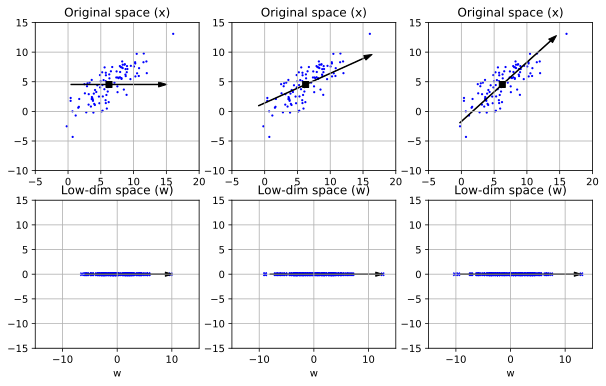

In [4]:
vfig

- **Goal:** Equivalently, minimize the reconstruction error over all the data points $\{\mathbf{x}_i\}_{i=1}^N$.
  - reconstruction: $\hat{\mathbf{x}}_i = \sum_{j=1}^p w_{i,j} \mathbf{v}_j$
  $$\min_{\mathbf{}w, \mathbf{v}} \sum_{i=1}^N ||\mathbf{x}_i - \hat{\mathbf{x}}_i||^2$$
  - _constraint:_ principal components $\mathbf{v}_j$ are orthogonal (perpendicular) to each other.
  

# PCA algorithm
- 1) subtract the mean of the data
- 2) the first PC $v_1$ is the direction that explains the most variance of the data.
- 3) the second PC $v_2$ is the direction perpendicular to $v_1$ that explains the most variance.
- 4) the third PC $v_3$ is the direction perpendicular to $\{v_1,v_2\}$ that explains the most variance.
- 5) ...


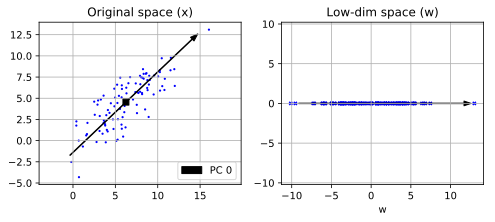

In [5]:
X = Xblob

# run PCA
pca = decomposition.PCA(n_components=1)
W   = pca.fit_transform(X)  # returns the coefficients

v = pca.components_  # the principal component vector
m = pca.mean_        # the data mean

plt.figure(figsize=(8,3))
plot_basis(X, v);

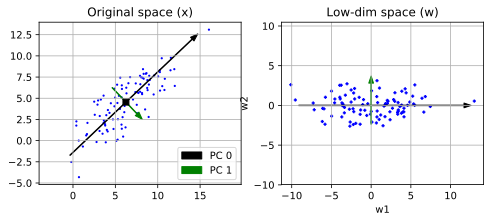

In [6]:
# run PCA
pca = decomposition.PCA(n_components=2)
W   = pca.fit_transform(X)

v = pca.components_  # the principal component vector
m = pca.mean_        # the data mean

plt.figure(figsize=(8,3))
plot_basis(X, v);

# Example on Iris data
- 2D (petal length, sepal width) to 1D

In [7]:
# example on Iris
axbox = [0, 8, 1.5, 5]

rbow = plt.get_cmap('rainbow')


# load iris data each row is (petal length, sepal width, class)
irisdata = loadtxt('iris3.csv', delimiter=',', skiprows=1)

Xiris = irisdata[:,0:2]  # the first two columns are features (petal length, sepal width)
Yiris = irisdata[:,2]    # the third column is the class label (setosa=0, versicolor=1, virginica=2)

X = Xiris
Y = Yiris

pca = decomposition.PCA(n_components=1)
W = pca.fit_transform(X)

ifig = plt.figure(figsize=(8,3))
axp = plot_basis(X, pca.components_)
plt.sca(axp[0])
plt.xlabel('petal length')
plt.ylabel('sepal width')
plt.close()

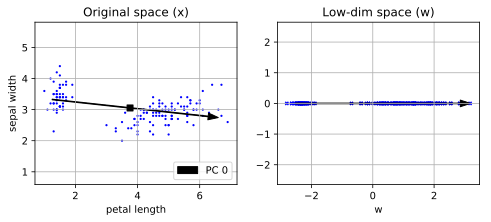

In [8]:
ifig

- 4D to 2D
- mostly preserves the structure of the classes.

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
[[ 0.36158968 -0.08226889  0.85657211  0.35884393]
 [ 0.65653988  0.72971237 -0.1757674  -0.07470647]]


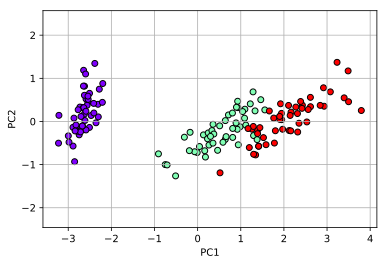

In [9]:
# get data
iris = datasets.load_iris()
X = iris.data
Y = iris.target

# run PCA
pca = decomposition.PCA(n_components=2)
W = pca.fit_transform(X)

print(iris.feature_names)
print(pca.components_)

plt.figure()
plt.scatter(W[:,0], W[:,1], c=Y, cmap=rbow, edgecolors='k')
plt.axis('equal'); plt.grid(True)
plt.xlabel('PC1'); plt.ylabel('PC2');

# How to choose the number of principal components?
- Two methods to set the number of components $p$:
  - preserve some percentage of the variance (e.g., 95%).
  - whatever works well for our final task (e.g., classification, regression).


# Handwritten digits data
- 1797 images of handwritten digits 0-9
  - each image is 8x8
  - flattened into a 64 dimensional vector

In [10]:
# get digit data
digits = datasets.load_digits()
Xdigits = float64(digits.data)
Ydigits = digits.target

print(Xdigits.shape)

(1797, 64)


In [11]:
def show_array_as_imgs(X, imgsize, plotwidth, titles=None, Xmask=None):
    "show each row of array X as an image"

    if X.ndim == 1:
        numX = 1
    else:
        numX = X.shape[0]
        
    height = ceil(numX/plotwidth)
    for n in range(numX):
        if (Xmask is None) or (Xmask[n]):
            plt.subplot(height,plotwidth,n+1)
            if numX > 1:
                I = X[n].reshape(imgsize)
            else:
                I = X.reshape(imgsize)
            plt.imshow(I, interpolation='nearest')
            plt.gray()
            if titles is not None:
                plt.title(str(titles[n]))
            plt.gca().xaxis.set_ticklabels([])
            plt.gca().yaxis.set_ticklabels([])

imgsize = (8,8)
# show examples
dfig = plt.figure(figsize=(8,3.5))
myi = range(0,1797,190)
show_array_as_imgs(Xdigits[myi], imgsize, 5, Ydigits[myi])
plt.close()

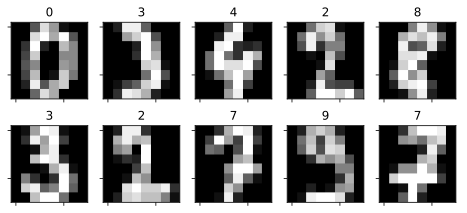

In [12]:
dfig

# Run PCA on the data
- split data into training and testing sets.
- run PCA on training set, apply to test set
- the top 25 PCs are shown

In [13]:
# randomly split data into 80% train and 20% test set
trainX, testX, trainY, testY = \
  model_selection.train_test_split(Xdigits, Ydigits, 
  train_size=0.5, test_size=0.5, random_state=4487)
Xdim = Xdigits.shape[1]

# run PCA
pca = decomposition.PCA() # default: n_components=dimension
W  = pca.fit_transform(trainX)  # fit the training set
Wt = pca.transform(testX)  # use the pca model to transform the test set

- Visualize the coefficients for the first two PCs.
  - grouping of different digits is sometimes preserved

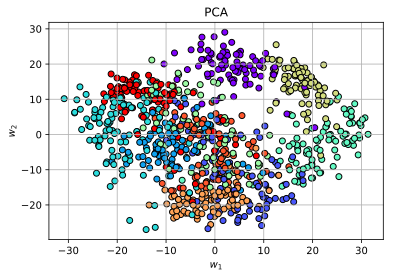

In [17]:
plt.figure()
plt.scatter(W[:,0], W[:,1], c=trainY, cmap=rbow, edgecolors='k')
plt.xlabel('$w_1$'); plt.ylabel('$w_2$')
plt.title('PCA'); plt.grid(True);

- Look at the mean and principal components

In [18]:
# plot the mean and the PCs
pcfig = plt.figure(figsize=(8,8))

tmpX = vstack((pca.mean_, pca.components_[range(24)]))
tmpT = ['mean']
for j in range(24):
    tmpT.append("PC " + str(j+1))

show_array_as_imgs(tmpX, imgsize, 5, tmpT)
plt.close()

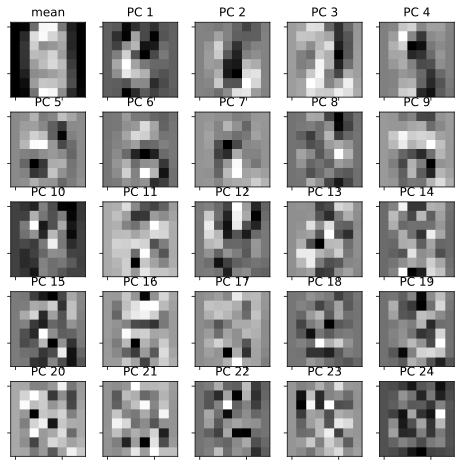

In [19]:
pcfig

- Reconstruction of a digit image from PC coefficients
  - using more PCs will make the reconstruction better

In [20]:
myX = trainX[0]
myW = W[0]
nump = 6

myR = zeros( (3*(nump+1), 64) )
myR[0] = myX
myT = ['Original', None, None]
Xmask = [True, False, False]

for i in range(nump):
    basei = (i+1)*3
    if i==0:
        myR[basei] = pca.mean_
        myT.append('mean')
    else:
        # take from previous result
        myR[basei] = myR[basei-1]
        myT.append(myT[basei-1][2:])
    
    # add PC
    myR[basei+1] = myW[i] * pca.components_[i]
    myT.append('+ PC' + str(i+1))
    # new recon
    myR[basei+2] = myR[basei+1] + myR[basei+0]
    myT.append('= Recon' + str(i+1))
    
    Xmask.append(True); Xmask.append(True); Xmask.append(True)

reconfig = plt.figure(figsize=(8,15))
show_array_as_imgs(myR, imgsize, 3, myT, Xmask=Xmask)
plt.close()

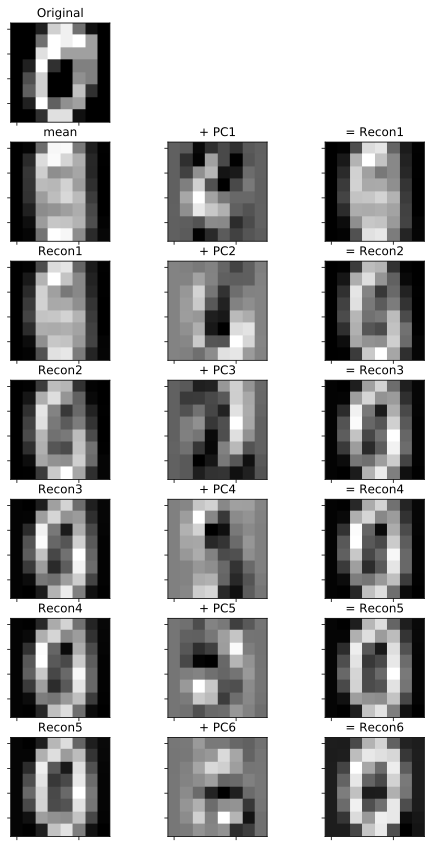

In [21]:
reconfig

# Explained variance
- each PC explains a percentage of the original data
  - this is called the _explained variance_.
  - PCs are already sorted by explained variance from highest to lowest
- pick the number of PCs to get a certain percentage of explained variance
  - typically 95%

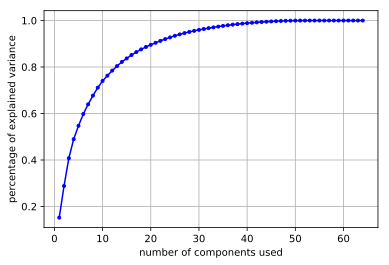

In [22]:
ev    = pca.explained_variance_ratio_  # variance explained by each component
cumev = cumsum(ev)                     # cumulative explained variance

plt.plot(range(1,Xdim+1), cumev, 'b.-')
plt.grid(True)
plt.xlabel('number of components used')
plt.ylabel('percentage of explained variance');

# Task-dependent Selection
- use results on the final task (in this case classification) to select the best number of components
- Note: we don't need to rerun PCA for each number of components
  - just select the subset of PCs based on the number of components desired.

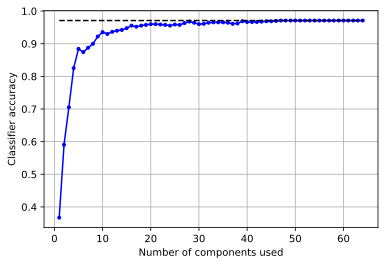

In [23]:
acc = zeros(Xdim)
for j in range(Xdim):
    # extract the subset of PC weights [0,j]
    Wnew     = W[:,0:(j+1)]
    Wnewtest = Wt[:,0:(j+1)]
    
    # train classifier
    clf = svm.SVC(kernel='linear', C=1)
    clf.fit(Wnew, trainY)

    # test classifier
    Ypred = clf.predict(Wnewtest)    
    acc[j] = metrics.accuracy_score(testY, Ypred)

# make a plot
plt.plot(range(1,Xdim+1), acc, '.b-')
plt.plot([1,Xdim], [acc.max(), acc.max()], 'k--')
plt.grid(True)
plt.xlabel('Number of components used')
plt.ylabel('Classifier accuracy');

- classification accuracy is stable after using 20 PCs.
  - not much loss in performance if using only 20 PCs.

# Random Projections
- If the data is very high-dimensional, then it might take too many calculations to do PCA.
  - Complexity: $O(d k^2)$, $d$ is the dimension, $k$ is the number of components
- Do we really need to estimate the principal components to reduce the dimension?

- **Solution:**
  - We can generate random basis vectors and use those.
    - Each entry of $\mathbf{v}_j$ sampled from a Gaussian.
  - This will save a lot of time.
  - Random Projections can reduce computation at the expense of losing some accuracy in the points (adding noise).

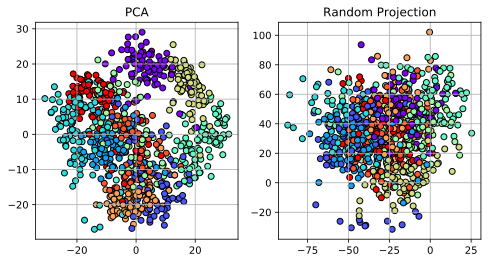

In [24]:
# project the digits data with Random Projection
rp = random_projection.GaussianRandomProjection(n_components=2, random_state=4487)
Wrp = rp.fit_transform(trainX)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.scatter(W[:,0], W[:,1], c=trainY, cmap=rbow, edgecolors='k'); plt.grid(True)
plt.title('PCA')
plt.subplot(1,2,2)
plt.scatter(Wrp[:,0], Wrp[:,1], c=trainY, cmap=rbow, edgecolors='k'); plt.grid(True)
plt.title('Random Projection');

- Okay, but is it good?
  - One way to measure "goodness" is to see if the structure of the data is preserved.
  - In other words, are distances between points preserved in the transformed data?
<center><img src="imgs/rp.jpg" width=500></center>

- **Answer:**
  - Yes!
  - According to the _Johnson-Lindenstrauss lemma_, carefully selecting the distribution of the random projection matrices will preserve the preserve the pairwise distances between any two samples of the dataset, within some error _epsilon_.
    - $ (1-\epsilon)\| \mathbf{x}_i - \mathbf{x}_j\|^2 < \|\mathbf{w}_i - \mathbf{w}_j\|^2 < (1+\epsilon) \| \mathbf{x}_i - \mathbf{x}_j\|^2$
    - the minimum reduced dimension $p$ to gaurantee $\epsilon$ error depends on the number of samples.
      - (actually, this is fairly conservative)

In [25]:
jlfig = plt.figure()
ns = 10**arange(1,7)
epss = arange(0.01, 1.00, 0.01)
for n in ns:
    mn = random_projection.johnson_lindenstrauss_min_dim(n_samples=n, eps=epss)
    plt.semilogy(epss, mn, label=str(n)+" samples")
plt.grid(True)
plt.xlabel('eps')
plt.ylabel('minimum number of reduced dimensions')
plt.legend(fontsize=9)
plt.close()

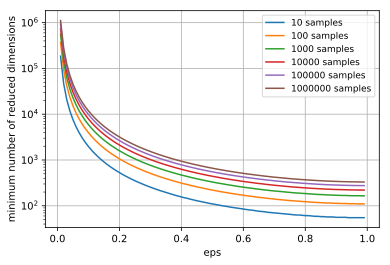

In [26]:
jlfig

- Example

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


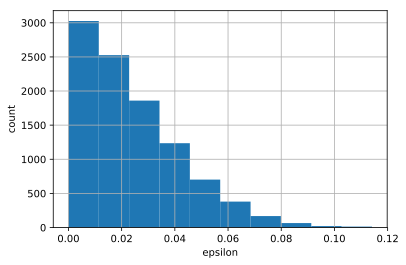

In [27]:
# generate random data
# (dimension=10000, samples=100)
X = random.rand(100,10000)

# fit to 500 components
rp = random_projection.GaussianRandomProjection(n_components=500, random_state=4487)
Wrp = rp.fit_transform(X)

# Calculate the pairwise distances 
D = metrics.pairwise.euclidean_distances(X, X)
Drp = metrics.pairwise.euclidean_distances(Wrp, Wrp)

# calculate epsilon
epss = abs(Drp/D-1)
epss[isnan(epss)] = 0 # remove 0/0
plt.hist(epss.flatten())
plt.xlabel('epsilon')
plt.ylabel('count')
plt.grid(True)


# Sparse Random Projection
- More computation can be saved by using a _sparse_ random projection matrix
  - "sparse" means that many entries in the basis vector are zero, so we can ignore those entries when multiplying.

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


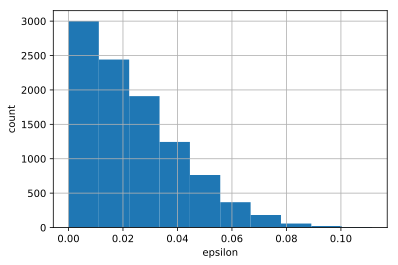

In [28]:
# project the digits data with Random Projection
srp = random_projection.SparseRandomProjection(n_components=500, random_state=4487)
Wsrp = srp.fit_transform(X)

# calculate pairwise distances
D = metrics.pairwise.euclidean_distances(X, X)
Dsrp = metrics.pairwise.euclidean_distances(Wsrp, Wsrp)

# calculate epsilon
epss = abs(Dsrp/D-1)
epss[isnan(epss)] = 0 # remove 0/0
plt.hist(epss.flatten())
plt.xlabel('epsilon')
plt.ylabel('count')
plt.grid(True)

# Question
- Suppose we have data for the below classification problem...
- We want to reduce the data to 1 dimension using PCA.
  - What is the first PC?

In [29]:
# example of PCA problem
random.seed(38)
Xbars,Ybars = datasets.make_blobs(300,2,[[-5,0], [5,0]], cluster_std=0.8)
Xbars[:,0] /=8

X = Xbars
Y = Ybars

efig = plt.figure(figsize=(5,4))
plt.scatter(X[:,0], X[:,1], c=Y, cmap=rbow, s=5, edgecolor="")
plt.axis('equal'); plt.grid(True)
plt.close()

e2fig = plt.figure(figsize=(8,4))
pca = decomposition.PCA(n_components=1)
W = pca.fit_transform(X)
plot_basis(X, pca.components_, Y=Y)
plt.close()

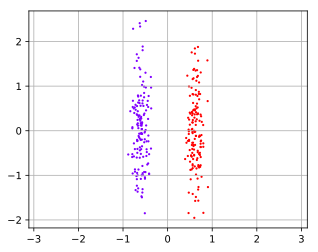

In [30]:
efig

# Answer
- first PC is along the direction of most variance.
  - collapses the two classes together!

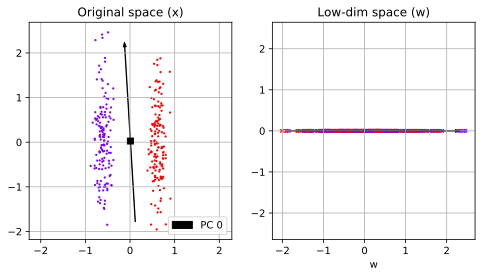

In [31]:
e2fig

# Problem with Unsupervised Methods
- If our end goal is classification, preserving the variance sometimes won't help!
  - PCA doesn't consider which class the data belongs to.
  - When the "classification" signal is less than the "noise", PCA will make classification more difficult.

# Fisher's Linear Discriminant (FLD)
- Supervised dimensionality reduction
- Also called _"Linear Discriminant Analysis"_ (LDA)
- **Goal:** find a lower-dim space so as to minimize the class overlap (or maximize the class separation).
  - data from each class is modeled as a Gaussian.
  - requires the class labels

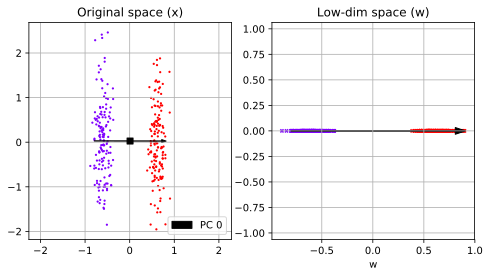

In [32]:
# example of FLD projection (using LDA name)
fld = discriminant_analysis.LinearDiscriminantAnalysis(n_components=1)
W  = fld.fit_transform(X, Y)

v = fld.coef_   # the basis vectors

plt.figure(figsize=(8,4))
plot_basis(X, v, Y=Y);

# On Iris data
- 4D vector to 2D vector
- FLD forms more compact classes
- With FLD, classes have less overlap if only using 1st basis vector.

In [33]:
# get data
X = iris.data  # 4D data
Y = iris.target

# run PCA
pca  = decomposition.PCA(n_components=2)
Wpca = pca.fit_transform(X)

# run LDA
fld   = discriminant_analysis.LinearDiscriminantAnalysis(n_components=2)
Wfld  = fld.fit_transform(X, Y)

ifig = plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.scatter(Wpca[:,0], Wpca[:,1], c=Y, cmap=rbow, edgecolors='k')
plt.axis('equal'); plt.grid(True)
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.title("PCA")
plt.subplot(1,2,2)
plt.scatter(Wfld[:,0], Wfld[:,1], c=Y, cmap=rbow, edgecolors='k')
plt.axis('equal'); plt.grid(True)
plt.xlabel('v1'); plt.ylabel('v2')
plt.title("FLD")
plt.close()

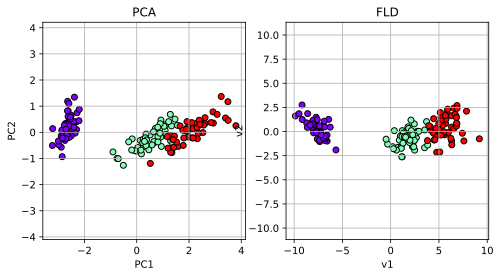

In [34]:
ifig